# Cluster Actors using a Matrix of Actor x Genre

Create a matrix of actors and the genres in which they've starred. Then, we'll use k-Means to extract clusters from the data in an unsupervised fashion.

In [3]:
%matplotlib inline


In [4]:
import pandas as pd

import json

In [5]:
actor_name_map = {}
movie_actor_map = {}
actor_genre_map = {}


with open("../data/imdb_movies_2000to2022.prolific.json", "r") as in_file:
    for line in in_file:
        
        # Read the movie on this line and parse its json
        this_movie = json.loads(line)
                    
        # Add all actors to the id->name map
        for actor_id,actor_name in this_movie['actors']:
            actor_name_map[actor_id] = actor_name
            
        # For each actor, add this movie's genres to that actor's list
        for actor_id,actor_name in this_movie['actors']:
            this_actors_genres = actor_genre_map.get(actor_id, {})
            
            # Increment the count of genres for this actor
            for g in this_movie["genres"]:
                this_actors_genres[g] = this_actors_genres.get(g, 0) + 1
                
            # Update the map
            actor_genre_map[actor_id] = this_actors_genres
            
        # Finished with this film
        movie_actor_map[this_movie["imdb_id"]] = ({
            "movie": this_movie["title"],
            "actors": set([item[0] for item in this_movie['actors']]),
            "genres": this_movie["genres"]
        })

In [6]:
# Check the output for actor Mel Gibson, actor ID nm0000154
actor_genre_map['nm0000154']

{'Adventure': 3,
 'Animation': 1,
 'Comedy': 7,
 'Drama': 12,
 'Mystery': 2,
 'Thriller': 10,
 'Action': 11,
 'History': 3,
 'Fantasy': 1,
 'Romance': 1,
 'Sci-Fi': 1,
 'Crime': 5,
 'Musical': 1,
 'Biography': 2}

In [7]:
# Get all actors as an index for a dataframe
index = actor_genre_map.keys()

# Get the genre-counts for each actor in the index
rows = [actor_genre_map[k] for k in index]

# Create the data frame from these rows, with the actors as index
df = pd.DataFrame(rows, index=index)

# Fill NAs with zero, as NA means the actor has not starred in that genre
df = df.fillna(0)

df

,Comedy,Fantasy,Romance,Drama,Mystery,Thriller,Action,Biography,Crime,War,...,Horror,Documentary,Sport,News,Family,Music,,Western,Short,Reality-TV
nm0000212,7.0,1.0,6.0,6.0,1.0,2.0,1.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0413168,7.0,3.0,5.0,12.0,5.0,2.0,14.0,4.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0000630,8.0,2.0,6.0,14.0,2.0,3.0,4.0,5.0,1.0,1.0,...,3.0,7.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0005227,10.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
nm0864851,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nm9504284,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm10592896,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm7216750,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nm0936300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Apply k-Means with a Fixed K

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [13]:
k = 8 # We pick k=8 for illustrative purposes only. You would need a more principled approach here.

C:\Users\octav\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\octav\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\octav\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Program Files\Python312\Lib\subprocess.py", line 548, in run
    with Popen(

Cluster 0:
nm1944040
nm1441824
nm2319866
nm6860498
nm3433021
Cluster 1:
nm0000498
nm0004988
nm4028885
nm0005085
nm1961459
Cluster 2:
nm3054665
nm10564066
nm2195419
nm2736476
nm0941374
Cluster 3:
nm0000616
nm0001803
nm0005458
nm0695177
nm0000115
Cluster 4:
nm2730580
nm2178959
nm2238248
nm0722647
nm0065493
Cluster 5:
nm0913460
nm0933988
nm0954225
nm0000667
nm5771748
Cluster 6:
nm0125653
nm0815370
nm0301381
nm0499614
nm2766218
Cluster 7:
nm0541909
nm0001758
nm0000154
nm2570245
nm0001427


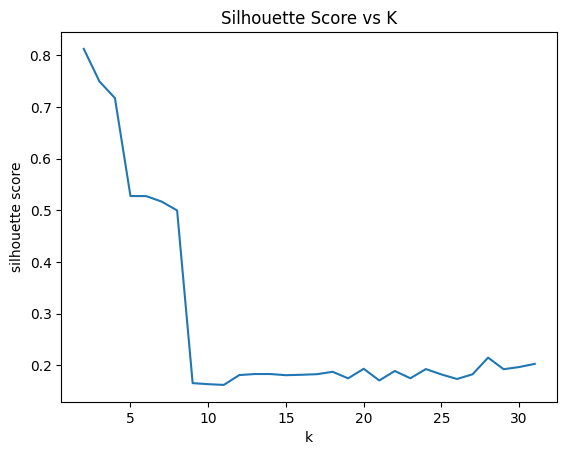

In [11]:
scores = []
for k in range(2, 32):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(df)
    score = silhouette_score(df, labels)
    scores.append((k, score))
  
ks, scores = zip(*scores)
plt.plot(ks, scores)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score vs K')

k = 8
kmeans = KMeans(n_clusters=k).fit(df) 
for i in range(k):
    cluster_df = df[kmeans.labels_==i] 
    print(f'Cluster {i}:') 
    for j in range(5):
        print(cluster_df.sample(1).index[0])